In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os, sys

!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

import xgboost as xgb
import optuna

def make_histograms(data1,data2):

    import matplotlib.pyplot as plt
    f, ax = plt.subplots(3,3,figsize=[15,12])
    for i,c in enumerate(data1.columns):
        y, x, _ = ax[i//3][i%3].hist(data1[c],bins=100,color='k')
        _ = ax[i//3][i%3].hist(data2[c],bins=100,color='r')
        ax[i//3][i%3].set_title(c)
        ax[i//3][i%3].set_yscale('log')
        medianfull = np.median(data1[c])
        medianredc = np.median(data2[c])

        meanfull = np.mean(data1[c])
        meanredc = np.mean(data2[c])

        ax[i//3][i%3].vlines(medianfull,y.max(),y.max()*10,color='c')
        ax[i//3][i%3].vlines(medianredc,y.max(),y.max()*10,color='m')
        ax[i//3][i%3].text(medianfull,y.max()*10,' MedianF',ha='left',color='c') # "F" means full
        ax[i//3][i%3].text(medianredc,y.max()*10,'MedianR ',ha='right',color='m') # "R" means reduced

        ax[i//3][i%3].vlines(meanfull,y.max()*20,y.max()*50,color='g')
        ax[i//3][i%3].vlines(meanredc,y.max()*20,y.max()*50,color='b')
        ax[i//3][i%3].text(meanfull,y.max()*50,' MeanF',ha='left',color='g')
        ax[i//3][i%3].text(meanredc,y.max()*50,'MeanR ',ha='right',color='b')

columns = ['T_e','T_bb','tau_T','E','Mu','I','U']
DF_full = pd.read_csv(path, names=columns )

In [11]:
def get_folds(DF,n_fold=2):
    """
    This function splits dataset into train, test and validation AND makes different folds.
    Parameters:
      DF - dataframe which should be splitted.
      n_folds - number of folds (default = 2), intiger.
    Return:
      Train_x, Test_x, Val_x - list of folds for features in training/test/validation sets
      Train_y, Test_y, Val_y - list of folds for labels in training/test/validation sets
    """

    # Number of folds. Means that the whole dataset is divided into n_fold parts of equal sizes.
    DF.reset_index(drop=True,inplace=True)
    X = DF.drop(['I','U'],axis=1)
    Y = np.log(DF['I'])

    # Create the KFold object.
    k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=0)

    # Train and test indices for each fold:
    train_test_idx_in_folds = {k: (train, test) for k, (train, test) in enumerate(k_fold.split(DF))}

    # Choose indices of train and test sets from fold 0:
    fold = 0

    Train_x,Train_y =[],[]
    Test_x,Test_y = [],[]
    Val_x,Val_y = [],[]

    for i in range(n_fold):
        train_idx = train_test_idx_in_folds[i][0]
        test_idx = train_test_idx_in_folds[i][1]

        # I would like to have validation set. In this approach I'll naively split test set in two.
        # We could implement different way to split but I don't think that this is needed at this point.
        L = len(test_idx)//2

        # Pick input data for train and test sets (i.e., cleaned XRD intensities):
        Train_x.append(X.loc[train_idx])
        Test_x.append(X.loc[test_idx[:L]])
        Val_x.append(X.loc[test_idx[L:]])

        # Pick output data for train and test sets (i.e., sample dimensionalities):
        Train_y.append(Y.loc[train_idx])
        Test_y.append(Y.loc[test_idx[:L]])
        Val_y.append(Y.loc[test_idx[L:]])

    return(Train_x,Test_x,Val_x,Train_y,Test_y,Val_y)


def PredPlot_folds(model,Tr_x,Tr_y,Te_x,Te_y,Validate=False,Validation_set=None,Verbose=False):
    """
    With this function I can iterate through the folds and execute fitting on each.
    Parameters:
      model - XGBRegression model
      Tr_x,Tr_Y,Te_x,Te_y - training and test data
      Validate - boolean value. If true model will be validated.
      Validation_set - data for validation (tuple of data)
      Verbose - set True to print out additional information
    """
    L = len(Tr_x)
    Y_pred = []
    for i in range(L):
        if Validate==False:
            model.fit(Tr_x[i],Tr_y[i],verbose=Verbose)
        else:
            model.fit(Tr_x[i],Tr_y[i],verbose=Verbose,eval_set=Validation_set)
        pred = model.predict(Te_x[i])
        print('Fold',i,'MAE:',mean_absolute_error(Te_y[i],pred))
        Y_pred.append(pred)


    Scores_all = []
    f, ax = plt.subplots(1,L,figsize=[20,5])
    for i in range(L):
        ax[i].scatter(Te_y[i],Y_pred[i],s=5,c='k')
        minmin = int(min(min(Te_y[i]),min(Y_pred[i])))
        maxmax = int(max(max(Te_y[i]),max(Y_pred[i])))
        R2 = round(r2_score(Te_y[i],Y_pred[i]),4)
        MAE = round(mean_absolute_error(Te_y[i],Y_pred[i]),4)
        ax[i].plot([i for i in range(minmin,maxmax)],[i for i in range(minmin,maxmax)],c='r')
        ax[i].text(minmin,maxmax,'R2:'+str(R2))
        ax[i].text(minmin,maxmax*0.8,'MAE:'+str(MAE))
        ax[i].set_xlabel('True values')
        ax[i].set_ylabel('Predicted values')
        ax[i].set_title('Fold '+str(i+1))
        Scores_all.append([R2,MAE])
    Scores_all = np.array(Scores_all)

    print('Mean R2:',np.mean(Scores_all[:,0]))
    print('Mean MAE:',np.mean(Scores_all[:,1]))

    return(Y_pred)


def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'learning_rate': trial.suggest_float('learning_rate', 10**-4,0.5,log=True),
        'n_estimators': trial.suggest_int('n_estimators', 64,8192),
        'gamma': trial.suggest_float('gamma', 0.00001,1,log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 10**-7, 50,log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 10**-7, 1.0,log=True)
        }

    model = xgb.XGBRegressor(**param,n_jobs=2,device='cuda')
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(Y_test, y_pred)


def objective_CV(trial):

    MAES = []
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'learning_rate': trial.suggest_float('learning_rate', 10**-5,0.2,log=True),
        'n_estimators': trial.suggest_int('n_estimators', 64,8192),
        'gamma': trial.suggest_float('gamma', 0.000001,1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 10**-5, 1000,log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 10**-5, 1.0,log=True)
        }

    model = xgb.XGBRegressor(**param,n_jobs=2)

    L = len(Tr_x)
    for i in range(L):
      X_train, X_test = Tr_x[i], Te_x[i]
      Y_train, Y_test = Tr_y[i], Te_y[i]
      model.fit(X_train, Y_train)
      y_pred = model.predict(X_test)
      MAES.append(mean_absolute_error(Y_test, y_pred))

    return(np.mean(MAES))

def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

optuna.logging.set_verbosity(optuna.logging.WARNING)

TRIALS = []

In [14]:
#for t in TRIALS:
#  print(t,'\n')
TRIALS = []
TRIALS.append({'max_depth': 3, 'learning_rate': 0.16196428501353416, 'n_estimators': 7577, 'gamma': 1.283667147323077e-05, 'colsample_bytree': 0.8104601460154854, 'reg_alpha': 1.4723782498068172e-06, 'reg_lambda': 1.8846139250404488e-07})
TRIALS.append({'max_depth': 3, 'learning_rate': 0.14242828484290956, 'n_estimators': 7688, 'gamma': 1.221855110042711e-05, 'colsample_bytree': 0.8414128592368463, 'reg_alpha': 1.8268550853154773e-06, 'reg_lambda': 0.9270907010531922})
TRIALS.append({'max_depth': 3, 'learning_rate': 0.17059233530509815, 'n_estimators': 6899, 'gamma': 1.5086854339838186e-05, 'colsample_bytree': 0.9447976513208292, 'reg_alpha': 7.229747007969654e-05, 'reg_lambda': 0.053106569363255765})
TRIALS.append({'max_depth': 4, 'learning_rate': 0.13357219049330188, 'n_estimators': 5507, 'gamma': 1.4121827894386388e-05, 'colsample_bytree': 0.7310381903441254, 'reg_alpha': 0.10711226399092046, 'reg_lambda': 0.9877855475642882})

In [ ]:
# Old params
 """
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.0005,0.2),
        'n_estimators': trial.suggest_int('n_estimators', 64,4096),
        'gamma': trial.suggest_float('gamma', 0,100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 100),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }
"""
#smthng

# 5K set

In [5]:
DF_5k = DF_full.sample(5000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5k,n_fold=3)

In [18]:
# 1) Hyperparameter optimization - objective based on single fold
X_train = Tr_x[0]
Y_train = Tr_y[0]
X_test = Te_x[0]
Y_test = Te_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')
study.enqueue_trial({'max_depth': 3, 'learning_rate': 0.11048815984489535, 'n_estimators': 1793,
                     'gamma': 6.938470341366783e-05, 'colsample_bytree': 0.9489028021911637,
                     'reg_alpha': 0.00211664308687754, 'reg_lambda': 1.2961527094174118e-05})
study.enqueue_trial({'max_depth': 3, 'learning_rate': 0.08311590356589299, 'n_estimators': 3843,
                      'gamma': 1.7956036005693712e-05, 'colsample_bytree': 0.8584733454594444,
                      'reg_alpha': 1.6747278348885998e-06, 'reg_lambda': 2.305347845170744e-05})
param = study.optimize(objective, n_trials=750,callbacks=[logging_callback])
params = study.best_params
val = study.best_value
print('Best value:',val)
print('Best parameters:\n',params)
TRIALS.append(params)

Best value: 0.1570048337729712, Best params: {'max_depth': 3, 'learning_rate': 0.11048815984489535, 'n_estimators': 1793, 'gamma': 6.938470341366783e-05, 'colsample_bytree': 0.9489028021911637, 'reg_alpha': 0.00211664308687754, 'reg_lambda': 1.2961527094174118e-05}
Best value: 0.13156835213728255, Best params: {'max_depth': 3, 'learning_rate': 0.08311590356589299, 'n_estimators': 3843, 'gamma': 1.7956036005693712e-05, 'colsample_bytree': 0.8584733454594444, 'reg_alpha': 1.6747278348885998e-06, 'reg_lambda': 2.305347845170744e-05}
Best value: 0.13156835213728255, Best params: {'max_depth': 3, 'learning_rate': 0.08311590356589299, 'n_estimators': 3843, 'gamma': 1.7956036005693712e-05, 'colsample_bytree': 0.8584733454594444, 'reg_alpha': 1.6747278348885998e-06, 'reg_lambda': 2.305347845170744e-05}
Best value: 0.13156835213728255, Best params: {'max_depth': 3, 'learning_rate': 0.08311590356589299, 'n_estimators': 3843, 'gamma': 1.7956036005693712e-05, 'colsample_bytree': 0.8584733454594444

{'max_depth': 3, 'learning_rate': 0.16196428501353416, 'n_estimators': 7577, 'gamma': 1.283667147323077e-05, 'colsample_bytree': 0.8104601460154854, 'reg_alpha': 1.4723782498068172e-06, 'reg_lambda': 1.8846139250404488e-07}
Fold 0 MAE: 0.12696445375994062
Fold 1 MAE: 0.17347307661498612
Fold 2 MAE: 0.13716754206758885
Mean R2: 0.9964333333333334
Mean MAE: 0.1459


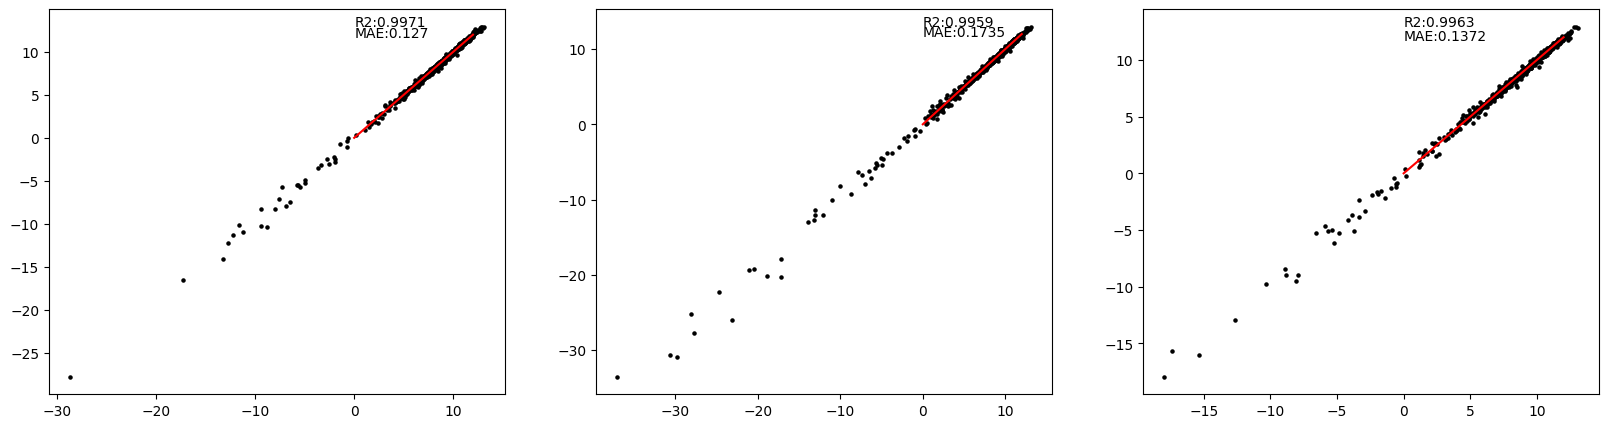

In [19]:
# 2) Cross-validation
print(params)
model = xgb.XGBRegressor(**params,n_jobs=2)
_ = PredPlot_folds(model,Tr_x,Tr_y,Te_x,Te_y,Validate=False,Validation_set=None,Verbose=False)

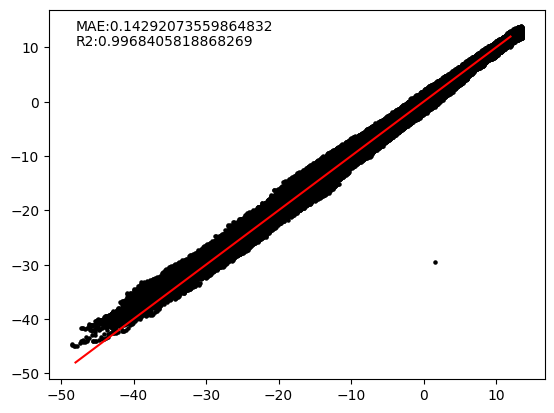

In [20]:
# 3) Predict full dataset

X,Y = DF_full.drop(['I','U'],axis=1), np.log(DF_full['I'])
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)
R2 = r2_score(Y,pred)
maxmax = int(max(max(Y),max(pred)))
minmin = int(min(min(Y),min(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(minmin,maxmax)],[i for i in range(minmin,maxmax)],color='r')
_ = plt.text(minmin,maxmax,'MAE:'+str(MAE))
_ = plt.text(minmin,maxmax*0.8,'R2:'+str(R2))

It can be seen that there is one stray datapoint.

#10K set

In [36]:
DF_10k = DF_full.sample(10000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_10k,n_fold=3)

In [28]:
# 1A) Hyperparameter optimization - objective based on single fold

start = time()
X_train = Tr_x[0]
Y_train = Tr_y[0]
X_test = Te_x[0]
Y_test = Te_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')

for T in TRIALS:
  study.enqueue_trial(T)
param = study.optimize(objective, n_trials=500,gc_after_trial=True,callbacks=[logging_callback])
params = study.best_params
val = study.best_value
stop = time()
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',stop-start,'In minutes:',(stop-start)//60)
TRIALS.append(params)

Trial 0 finished with best value: 0.09038928065660598 and parameters: {'max_depth': 3, 'learning_rate': 0.16196428501353416, 'n_estimators': 7577, 'gamma': 1.283667147323077e-05, 'colsample_bytree': 0.8104601460154854, 'reg_alpha': 1.4723782498068172e-06, 'reg_lambda': 1.8846139250404488e-07}. 
Trial 110 finished with best value: 0.09002477996736132 and parameters: {'max_depth': 3, 'learning_rate': 0.10765217414643607, 'n_estimators': 6928, 'gamma': 1.6444432845455672e-05, 'colsample_bytree': 0.8302718296527559, 'reg_alpha': 4.090436209107256e-07, 'reg_lambda': 5.8727041480136626e-06}. 
Trial 112 finished with best value: 0.08914376647154167 and parameters: {'max_depth': 3, 'learning_rate': 0.13652729450886994, 'n_estimators': 6892, 'gamma': 1.0503102642486325e-05, 'colsample_bytree': 0.828411237574103, 'reg_alpha': 8.898987408122909e-07, 'reg_lambda': 8.573430488274508e-06}. 
Trial 142 finished with best value: 0.08881045494062846 and parameters: {'max_depth': 3, 'learning_rate': 0.19

Fold 0 MAE: 0.08773013031997046
Fold 1 MAE: 0.09477468097803617
Fold 2 MAE: 0.09762402416928251
Mean R2: 0.9987666666666667
Mean MAE: 0.09336666666666667


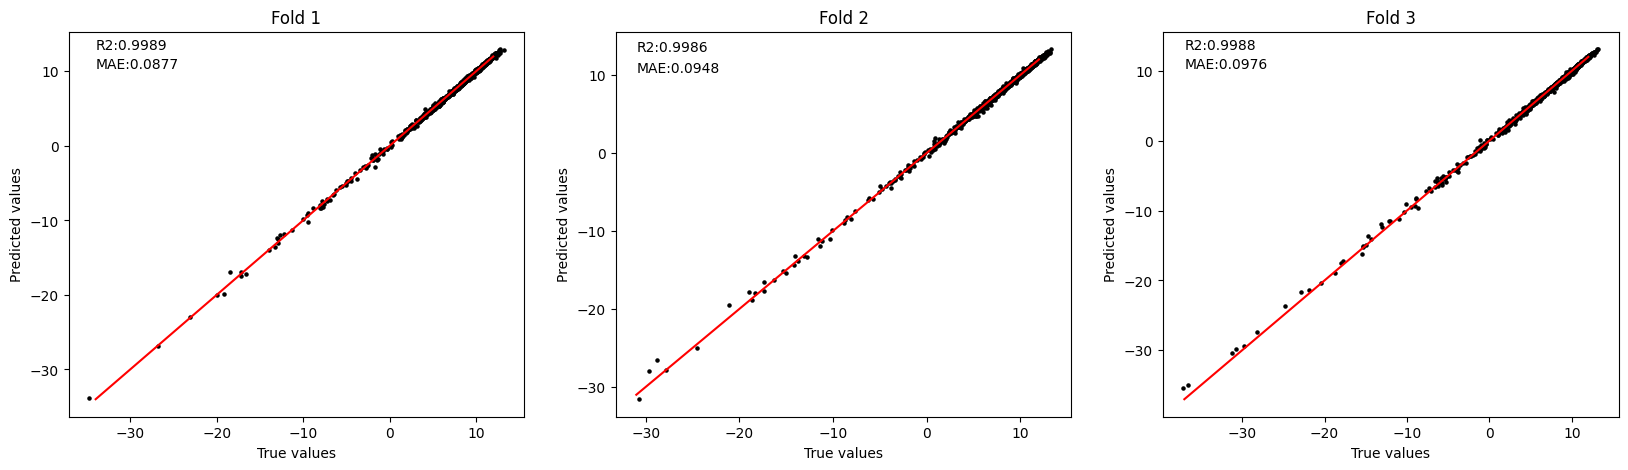

In [41]:
# 2A) Cross-validation
model = xgb.XGBRegressor(**params,n_jobs=2)
_ = PredPlot_folds(model,Tr_x,Tr_y,Te_x,Te_y,Validate=False,Validation_set=None,Verbose=False)

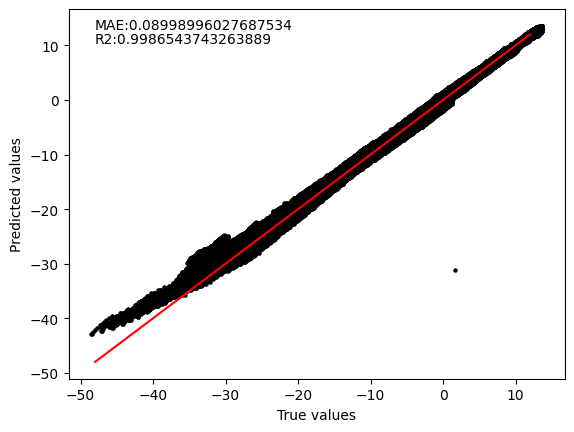

In [31]:
# 3) Predict full dataset

X,Y = DF_full.drop(['I','U'],axis=1), np.log(DF_full['I'])
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)
R2 = r2_score(Y,pred)
maxmax = int(max(max(Y),max(pred)))
minmin = int(min(min(Y),min(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.plot([i for i in range(minmin,maxmax)],[i for i in range(minmin,maxmax)],color='r')
_ = plt.text(minmin,maxmax,'MAE:'+str(MAE))
_ = plt.text(minmin,maxmax*0.8,'R2:'+str(R2))

# 15K set

In [42]:
DF_15k = DF_full.sample(15000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_15k,n_fold=3)

In [43]:
# 1A) Hyperparameter optimization - objective based on single fold

start = time()
X_train = Tr_x[0]
Y_train = Tr_y[0]
X_test = Te_x[0]
Y_test = Te_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')

for T in TRIALS:
  study.enqueue_trial(T)
study.optimize(objective, n_trials=300,gc_after_trial=True,callbacks=[logging_callback])
params = study.best_params
val = study.best_value
stop = time()
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',stop-start,'In minutes:',(stop-start)//60)
TRIALS.append(params)

Trial 0 finished with best value: 1.475420299696648 and parameters: {'max_depth': 21, 'learning_rate': 0.0016996898497535274, 'n_estimators': 6899, 'gamma': 0.22229448595964613, 'colsample_bytree': 0.07919792662073877, 'reg_alpha': 0.17131135005199655, 'reg_lambda': 2.560694275607829e-05}. 
Trial 1 finished with best value: 0.8275230516470597 and parameters: {'max_depth': 18, 'learning_rate': 0.01351230306923035, 'n_estimators': 5956, 'gamma': 0.0002110536429280716, 'colsample_bytree': 0.5812930248937525, 'reg_alpha': 8.439251046878946e-07, 'reg_lambda': 0.6415719400376863}. 
Trial 4 finished with best value: 0.5350261577495575 and parameters: {'max_depth': 13, 'learning_rate': 0.038601834220490405, 'n_estimators': 3498, 'gamma': 3.607182154430665e-05, 'colsample_bytree': 0.9112952458334139, 'reg_alpha': 0.0006508552756390242, 'reg_lambda': 3.52415294901004e-05}. 
Trial 10 finished with best value: 0.3683159439605487 and parameters: {'max_depth': 10, 'learning_rate': 0.3641703964009772

Fold 0 MAE: 0.0755273879456134
Fold 1 MAE: 0.07853379180485481
Fold 2 MAE: 0.08153705061265104
Mean R2: 0.9991666666666666
Mean MAE: 0.0785


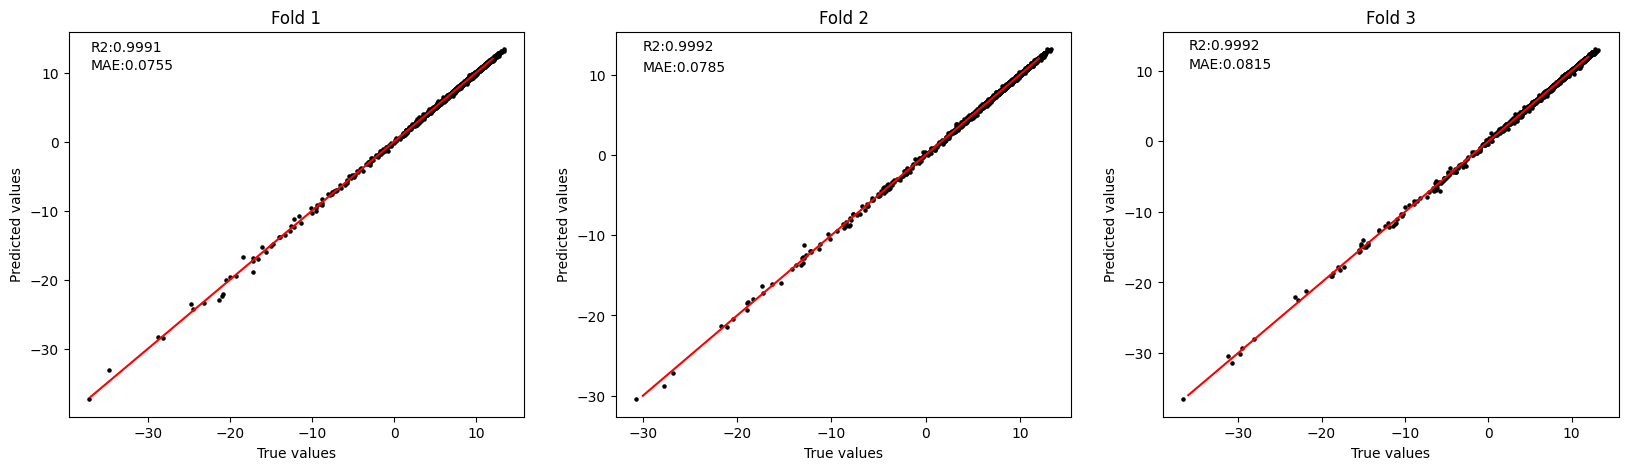

In [44]:
# 2A) Cross-validation
model = xgb.XGBRegressor(**params,n_jobs=2)
_ = PredPlot_folds(model,Tr_x,Tr_y,Te_x,Te_y,Validate=False,Validation_set=None,Verbose=False)

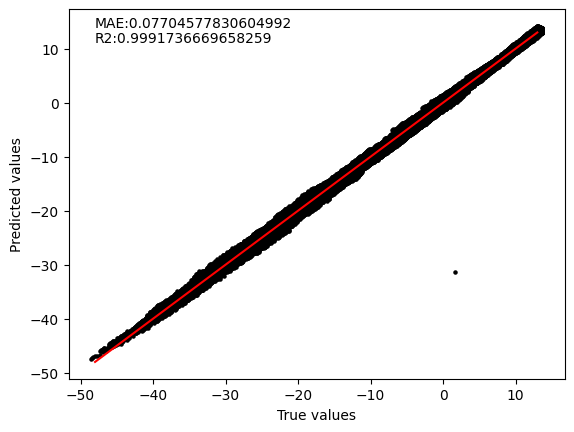

In [47]:
# 3) Predict full dataset

X,Y = DF_full.drop(['I','U'],axis=1), np.log(DF_full['I'])
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)
R2 = r2_score(Y,pred)
maxmax = int(max(max(Y),max(pred)))
minmin = int(min(min(Y),min(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.plot([i for i in range(minmin,maxmax)],[i for i in range(minmin,maxmax)],color='r')
_ = plt.text(minmin,maxmax,'MAE:'+str(MAE))
_ = plt.text(minmin,maxmax*0.8,'R2:'+str(R2))

# 30K set

In [7]:
DF_30k = DF_full.sample(30000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_30k,n_fold=3)

In [15]:
# 1A) Hyperparameter optimization - objective based on single fold

start = time()
X_train = Tr_x[0]
Y_train = Tr_y[0]
X_test = Te_x[0]
Y_test = Te_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')

for T in TRIALS:
  study.enqueue_trial(T)
study.optimize(objective, n_trials=300,gc_after_trial=True,callbacks=[logging_callback])
params = study.best_params
val = study.best_value
stop = time()
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',stop-start,'In minutes:',(stop-start)//60)
TRIALS.append(params)

Trial 0 finished with best value: 0.06264351688878858 and parameters: {'max_depth': 3, 'learning_rate': 0.16196428501353416, 'n_estimators': 7577, 'gamma': 1.283667147323077e-05, 'colsample_bytree': 0.8104601460154854, 'reg_alpha': 1.4723782498068172e-06, 'reg_lambda': 1.8846139250404488e-07}. 
Trial 31 finished with best value: 0.061858174885078165 and parameters: {'max_depth': 3, 'learning_rate': 0.17596912280491656, 'n_estimators': 7272, 'gamma': 1.9455151375006167e-05, 'colsample_bytree': 0.9106373986001483, 'reg_alpha': 6.994264572465665e-07, 'reg_lambda': 0.7993881788137206}. 
Trial 51 finished with best value: 0.06183950903885459 and parameters: {'max_depth': 3, 'learning_rate': 0.13186035891130318, 'n_estimators': 7909, 'gamma': 1.1919994229716453e-05, 'colsample_bytree': 0.9477353330912446, 'reg_alpha': 3.400751603797336e-07, 'reg_lambda': 0.5633766258716342}. 
Trial 53 finished with best value: 0.054370736198166104 and parameters: {'max_depth': 3, 'learning_rate': 0.482469390

Fold 0 MAE: 0.054370736198166104
Fold 1 MAE: 0.06422117348677683
Fold 2 MAE: 0.05502468903911426
Mean R2: 0.9994666666666667
Mean MAE: 0.05786666666666666


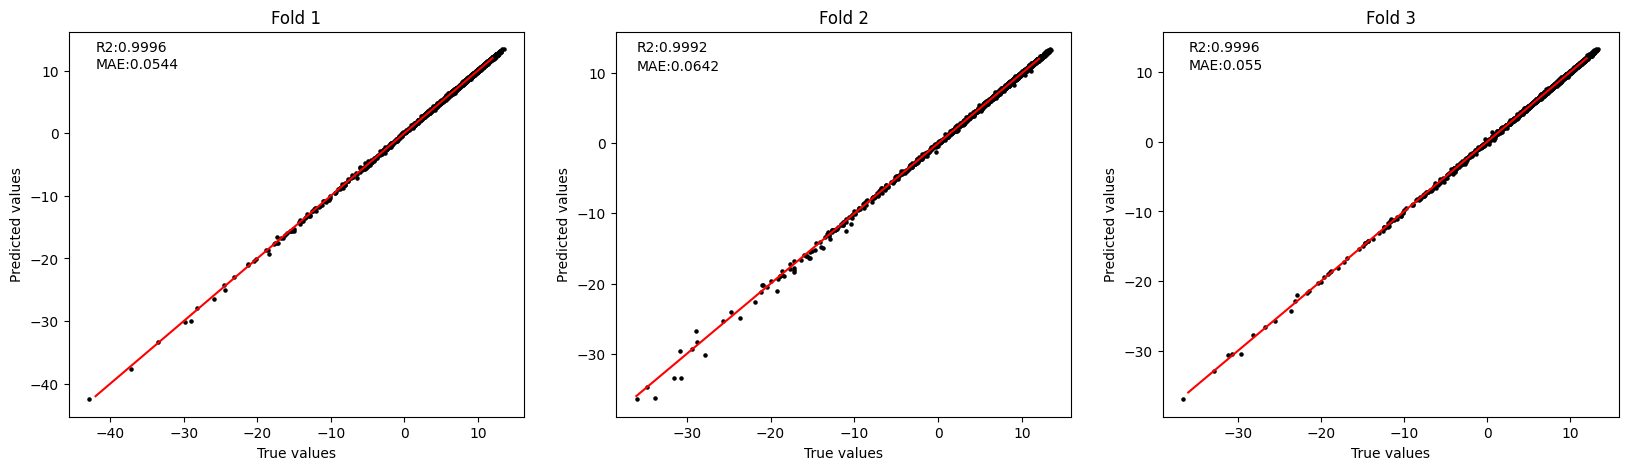

In [16]:
# 2) Cross-validation
model = xgb.XGBRegressor(**params,n_jobs=2,device='gpu')
_ = PredPlot_folds(model,Tr_x,Tr_y,Te_x,Te_y,Validate=False,Validation_set=None,Verbose=False)

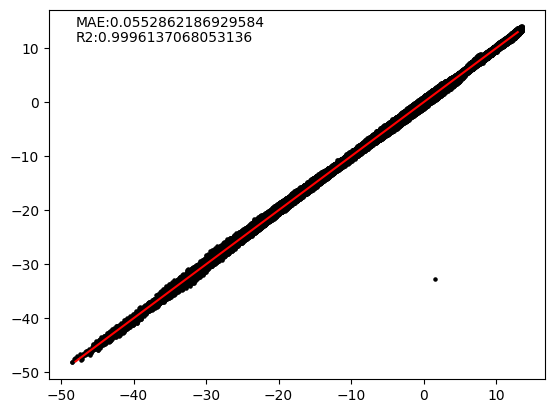

In [17]:
# 3) Predict full dataset
X,Y = DF_full.drop(['I','U'],axis=1), np.log(DF_full['I'])
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)
R2 = r2_score(Y,pred)
maxmax = int(max(max(Y),max(pred)))
minmin = int(min(min(Y),min(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(minmin,maxmax)],[i for i in range(minmin,maxmax)],color='r')
_ = plt.text(minmin,maxmax,'MAE:'+str(MAE))
_ = plt.text(minmin,maxmax*0.8,'R2:'+str(R2))